In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import f_classif
import shap
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'shap'

In [ ]:
df_with_emotions = pd.read_csv("df_with_emotions.csv")

In [ ]:
# Step 1: Data Preparation
# Drop or encode categorical/text columns
df_clean = df_with_emotions.drop(columns=['Student_ID', 'Daily_Reflections', 'Mental_Health_Status'])

# Encode 'Gender' (categorical) as numeric
le_gender = LabelEncoder()
df_clean['Gender'] = le_gender.fit_transform(df_clean['Gender'])

# Extract features for clustering
X = df_clean.values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

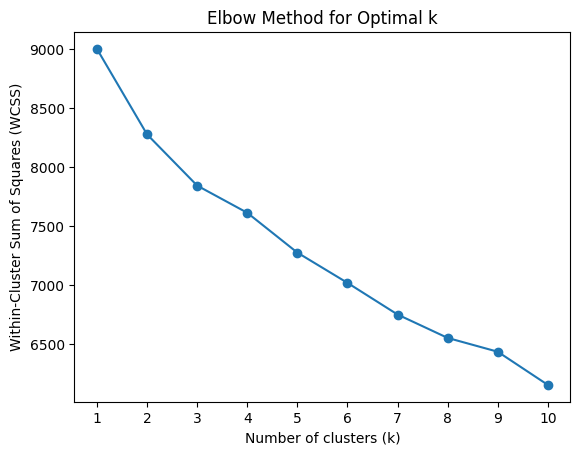

In [ ]:
# Step 2: Choose K with Elbow method
wcss = []
K_range = range(1, 11)  # Usually start from 1 for elbow plot

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(K_range)
plt.show()


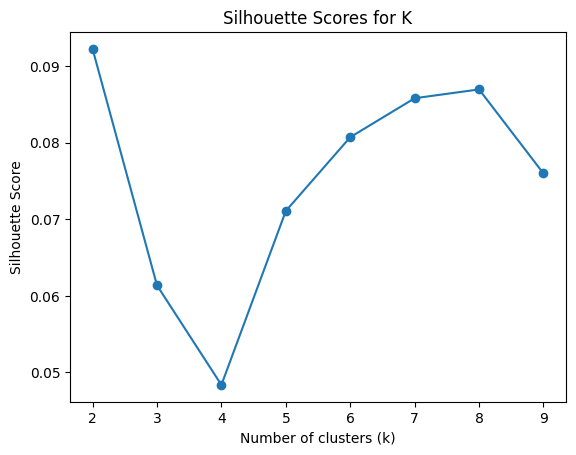

Best number of clusters: 2


In [ ]:
# Step 2: Choose K with Elbow or Silhouette
sil_scores = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Scores for K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Choose k with highest silhouette score
best_k = K_range[np.argmax(sil_scores)]
print(f"Best number of clusters: {best_k}")

In [ ]:
# Step 3: Fit final model
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_with_emotions['Cluster'] = clusters

In [ ]:
# Step 4: ANOVA to find features differing by cluster
f_values, p_values = f_classif(X_scaled, clusters)
feature_names = df_clean.columns

anova_results = pd.DataFrame({
    'Feature': feature_names,
    'F_value': f_values,
    'p_value': p_values
}).sort_values('p_value')

print("ANOVA results (features significantly differing across clusters):")
print(anova_results[anova_results['p_value'] < 0.05])

ANOVA results (features significantly differing across clusters):
             Feature     F_value       p_value
8               fear  228.037392  1.081497e-42
17          positive  162.928323  1.762952e-32
16          negative  149.677016  2.819739e-30
11             trust   84.623340  9.899448e-19
14               joy   70.651686  4.502129e-16
9              anger   70.457753  4.906945e-16
13           sadness   67.921224  1.517743e-15
15           disgust   21.931717  3.648750e-06
10      anticipation   17.407438  3.559345e-05
4      Anxiety_Score   16.298364  6.263418e-05
5   Depression_Score    7.491298  6.421455e-03


c:\Users\hp\anaconda3\envs\deep-seek-crawler\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:11:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


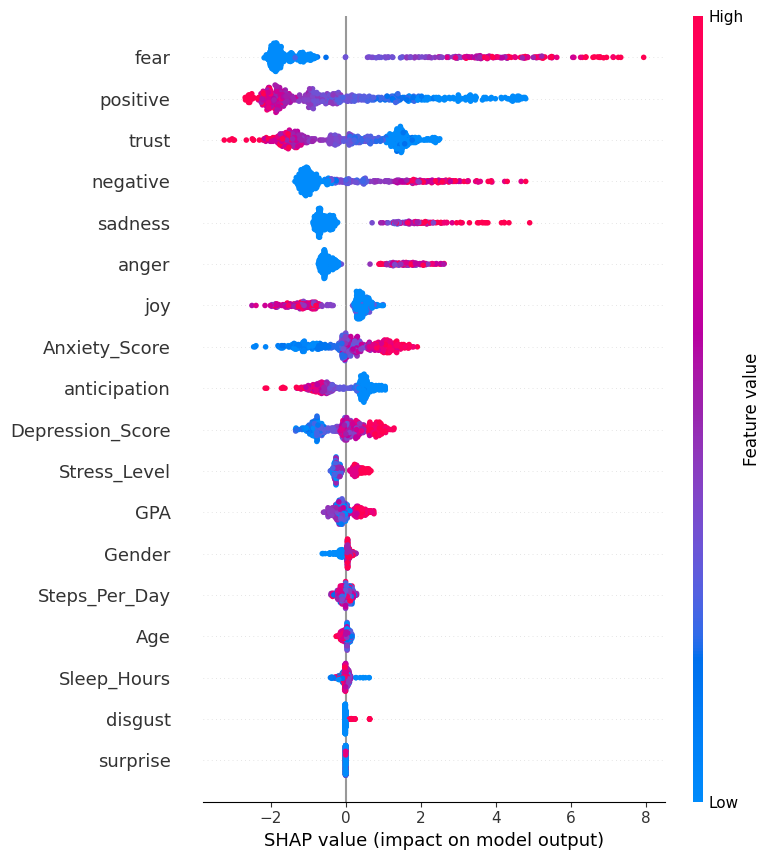

SHAP summary for cluster 0


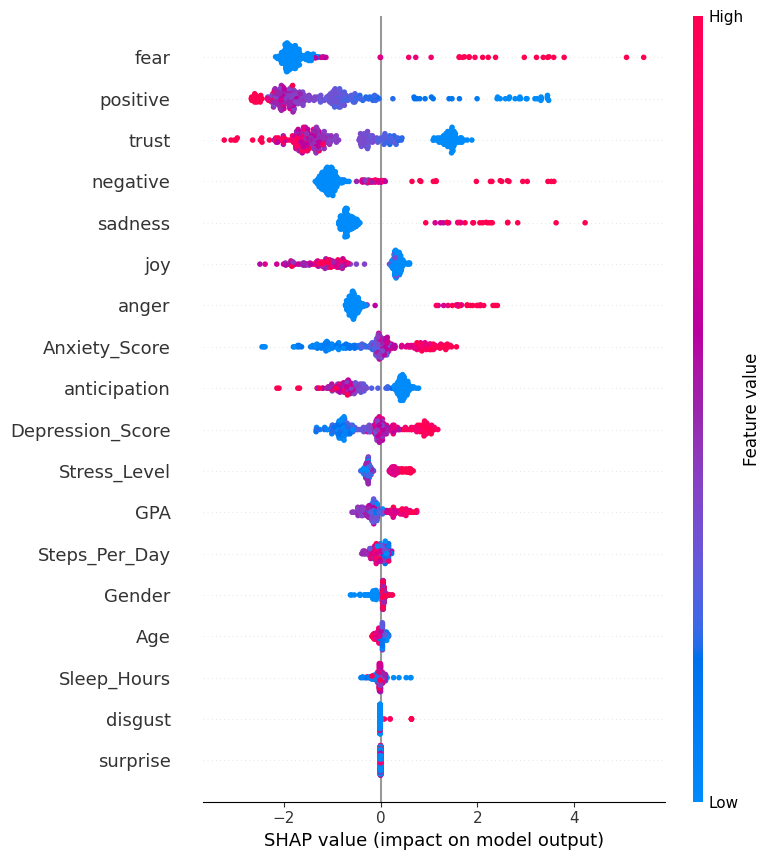

SHAP summary for cluster 1


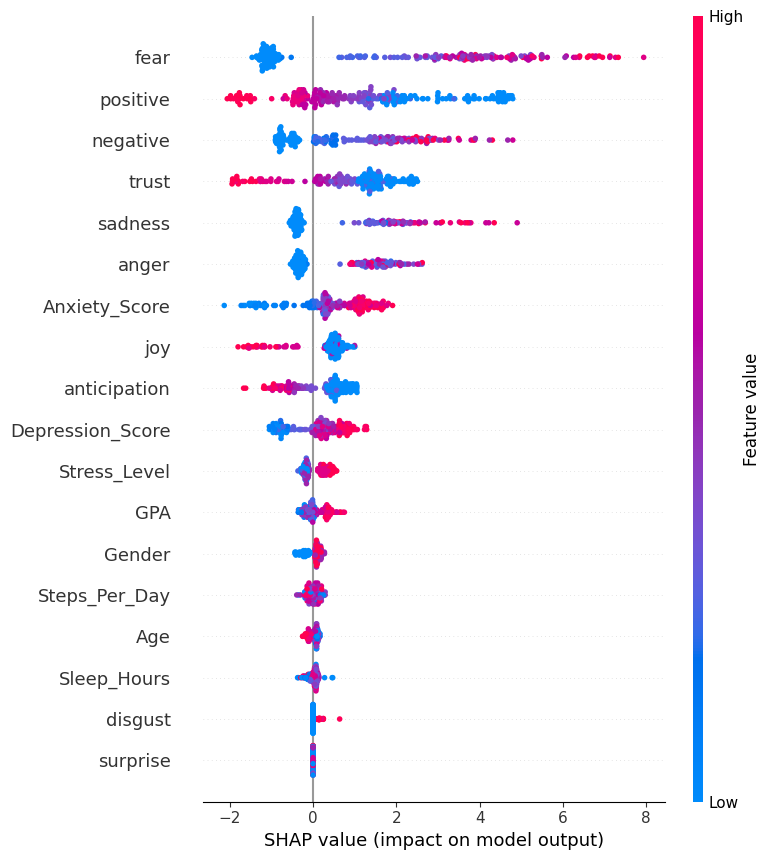

In [ ]:
# Step 5: SHAP interpretation

# Train a classifier to predict cluster labels (use simple model like XGBoost or RandomForest)
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_scaled, clusters)

explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# Plot summary
shap.summary_plot(shap_values, features=X_scaled, feature_names=feature_names)

# To analyze cluster-wise patterns:
for cluster_label in range(best_k):
    print(f"SHAP summary for cluster {cluster_label}")
    idx = (clusters == cluster_label)
    shap.summary_plot(shap_values[idx], features=X_scaled[idx], feature_names=feature_names)

c:\Users\hp\anaconda3\envs\deep-seek-crawler\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\hp\anaconda3\envs\deep-seek-crawler\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\hp\anaconda3\envs\deep-seek-crawler\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\hp\anaconda3\envs\deep-seek-crawler\Lib\site-packages\seaborn\axisgrid.py:85

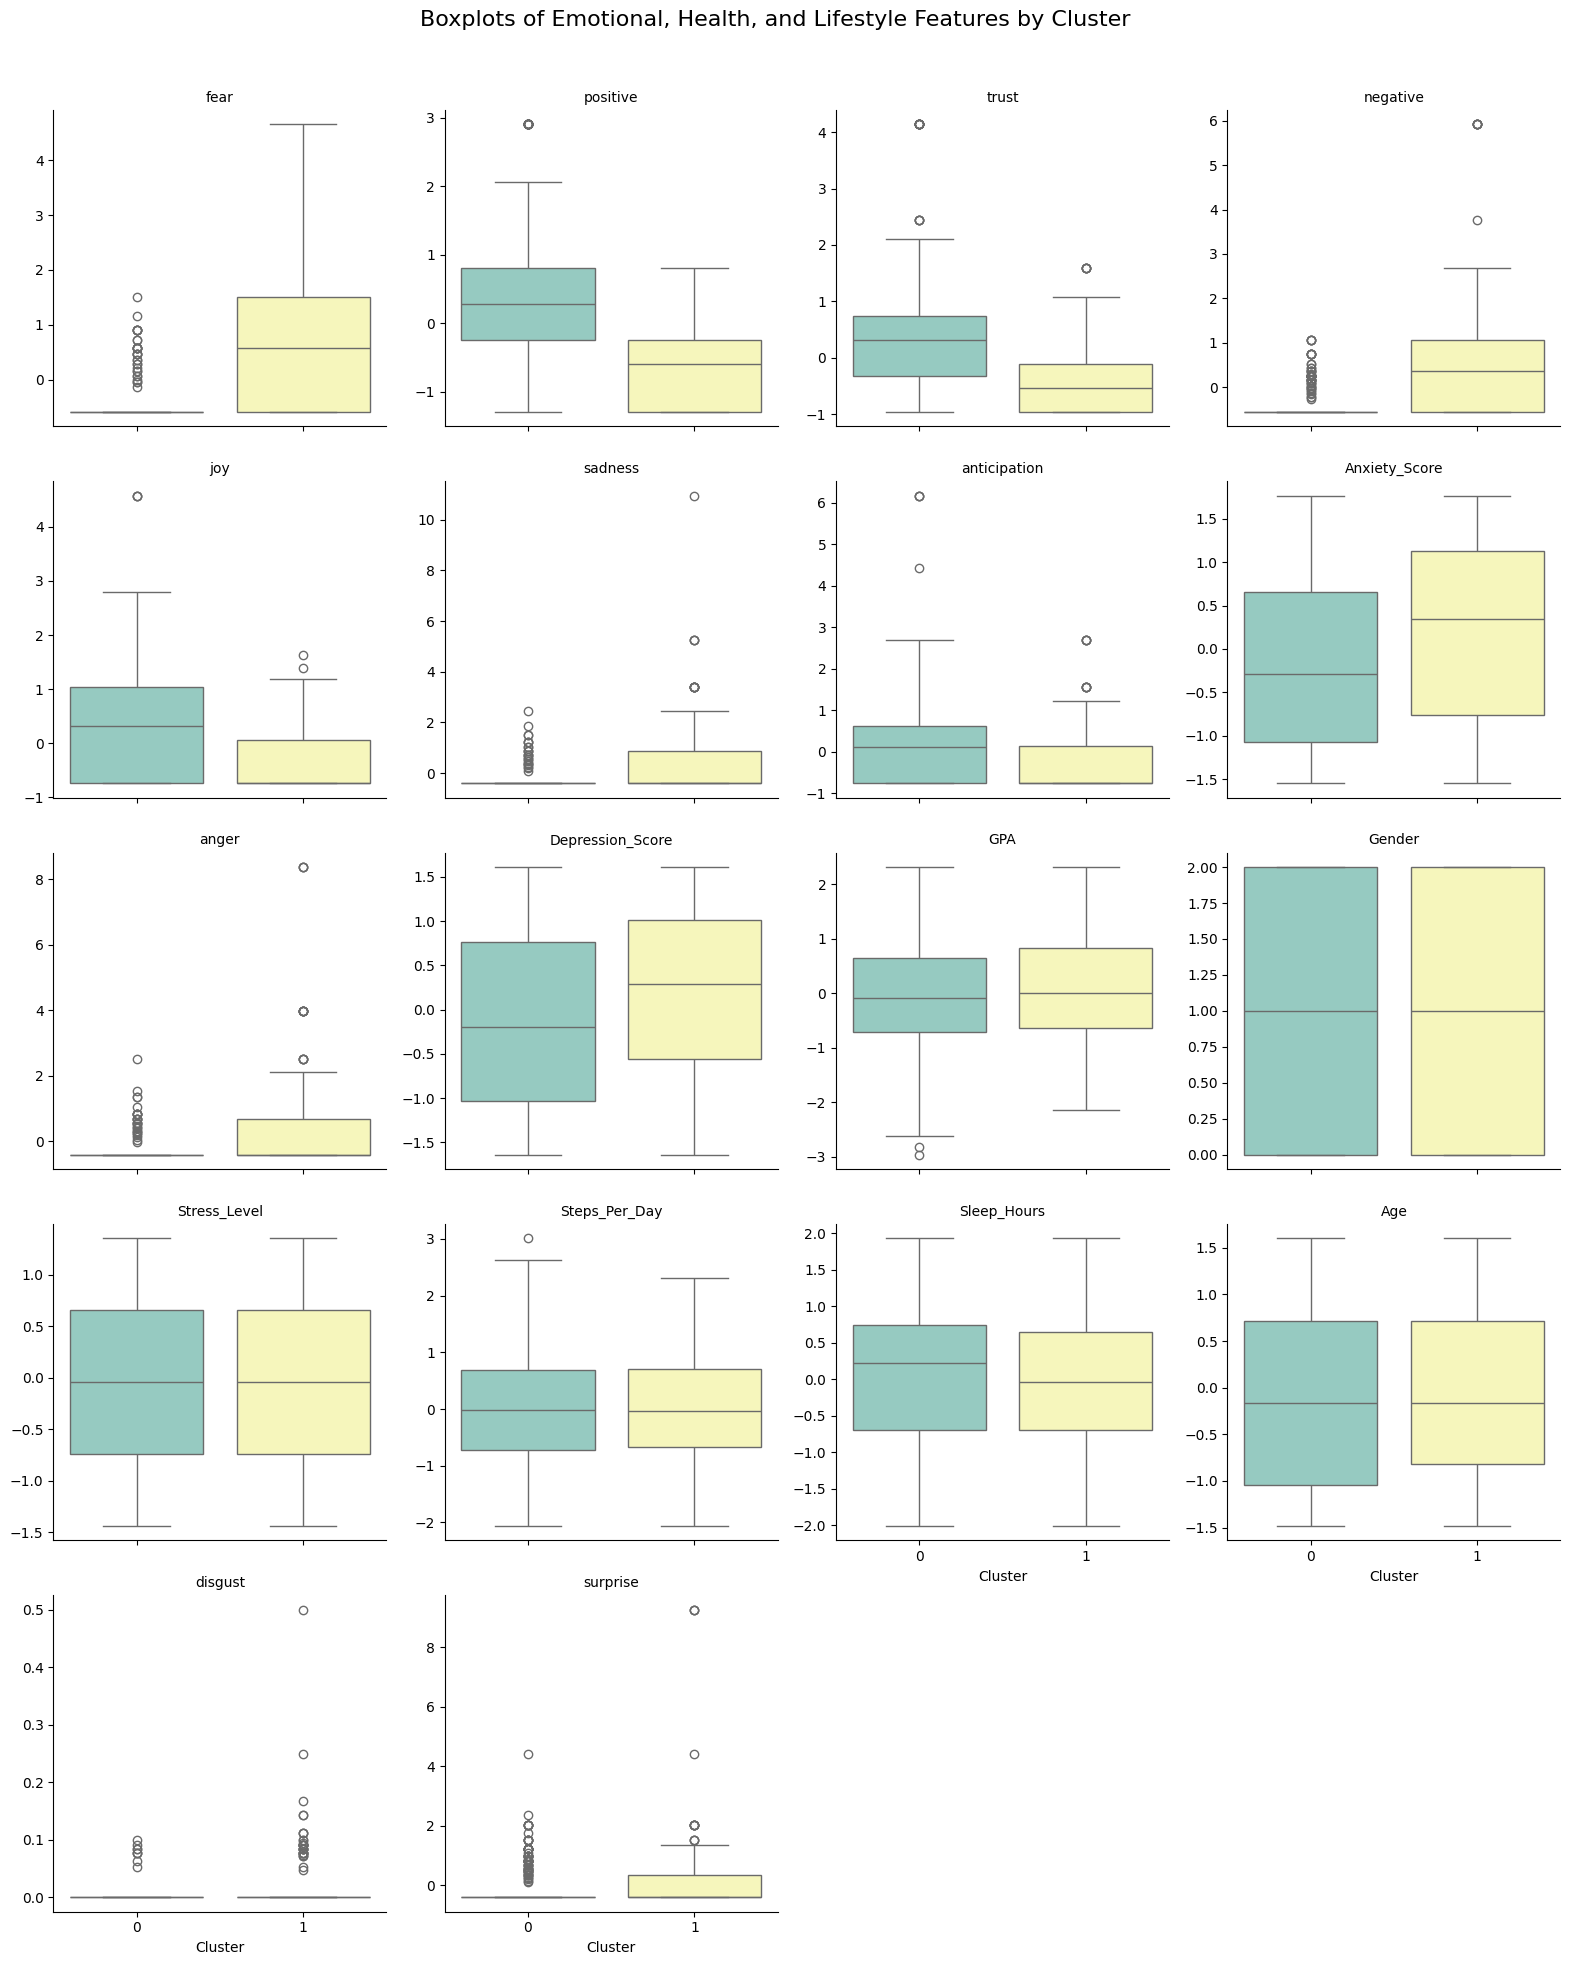

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_clean['Cluster'] = clusters
# Define the custom-ordered list of columns to compare
columns_to_compare = [
    'fear', 'positive', 'trust', 'negative', 'joy', 'sadness',
    'anticipation', 'Anxiety_Score', 'anger', 'Depression_Score',
    'GPA', 'Gender', 'Stress_Level', 'Steps_Per_Day', 'Sleep_Hours',
    'Age', 'disgust', 'surprise'
]

# Melt the DataFrame to long format for FacetGrid
df_melted = df_clean.melt(
    id_vars='Cluster', 
    value_vars=columns_to_compare,
    var_name='Feature',
    value_name='Value'
)

# Set the FacetGrid plot
g = sns.FacetGrid(
    df_melted, 
    col='Feature', 
    col_wrap=4, 
    sharey=False, 
    height=4
)

g.map_dataframe(sns.boxplot, x='Cluster', y='Value', palette='Set3')

# Aesthetics
g.set_titles("{col_name}")
g.set_axis_labels("Cluster", "")
plt.subplots_adjust(top=0.93)
g.fig.suptitle("Boxplots of Emotional, Health, and Lifestyle Features by Cluster", fontsize=16)
plt.show()


In [ ]:
# Contingency table (cross-tabulation)
ct = pd.crosstab(df_with_emotions['Cluster'], df_with_emotions['Mental_Health_Status'])
print(ct)

# Relative frequencies (proportions within clusters)
print(ct.div(ct.sum(axis=1), axis=0))

# Chi-square test to assess association
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi-square test p-value: {p}")
if p < 0.05:
    print("There is a statistically significant association between cluster and mental health status.")
else:
    print("No statistically significant association detected.")


Mental_Health_Status   0   1    2
Cluster                          
0                     19  86  188
1                      3  51  153
Mental_Health_Status         0         1         2
Cluster                                           
0                     0.064846  0.293515  0.641638
1                     0.014493  0.246377  0.739130
Chi-square test p-value: 0.007969559656124739
There is a statistically significant association between cluster and mental health status.


In [ ]:
df_clean.describe()

,Age,Gender,GPA,Stress_Level,Anxiety_Score,Depression_Score,Sleep_Hours,Steps_Per_Day,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive,Cluster
count,5.000000e+02,500.00000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000,5.000000e+02,500.000000
mean,1.705303e-16,0.98800,-7.105427e-18,1.527667e-16,9.237056e-17,-5.329071e-17,-1.953993e-17,1.030287e-16,7.993606e-17,8.704149e-17,-1.065814e-16,-3.552714e-17,-1.065814e-16,-4.085621e-17,2.486900e-17,0.008397,0.000000,-4.973799e-17,0.414000
std,1.001002e+00,0.81559,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,0.034767,1.001002,1.001002e+00,0.493042
min,-1.482367e+00,0.00000,-2.962997e+00,-1.441515e+00,-1.547845e+00,-1.639176e+00,-2.012722e+00,-2.062126e+00,-5.890062e-01,-4.039064e-01,-7.541154e-01,-9.597850e-01,-4.091892e-01,-4.015649e-01,-7.393428e-01,0.000000,-0.558704,-1.297918e+00,0.000000
25%,-1.041973e+00,0.00000,-6.836787e-01,-7.424294e-01,-9.168441e-01,-9.169660e-01,-6.991063e-01,-6.929978e-01,-5.890062e-01,-4.039064e-01,-7.541154e-01,-9.597850e-01,-4.091892e-01,-4.015649e-01,-7.393428e-01,0.000000,-0.558704,-5.973121e-01,0.000000
50%,-1.611843e-01,1.00000,-4.079396e-02,-4.334333e-02,2.965703e-02,4.598071e-02,5.622275e-02,-2.434187e-02,-5.890062e-01,-4.039064e-01,-2.212001e-01,-1.101929e-01,-4.091892e-01,-4.015649e-01,-7.393428e-01,0.000000,-0.558704,-9.687956e-02,0.000000
75%,7.196043e-01,2.00000,7.384602e-01,6.557427e-01,8.184080e-01,8.885591e-01,6.801902e-01,7.000882e-01,4.597574e-01,1.541610e-01,5.055026e-01,4.304567e-01,1.441884e-01,-4.015649e-01,7.790655e-01,0.000000,0.366572,5.036395e-01,1.000000
max,1.600393e+00,2.00000,2.316450e+00,1.354829e+00,1.764909e+00,1.610769e+00,1.928125e+00,3.008251e+00,4.654812e+00,8.378792e+00,6.173784e+00,4.137768e+00,9.249766e+00,1.095110e+01,4.575086e+00,0.500000,5.918226,2.905716e+00,1.000000


In [ ]:
df_with_emotions.describe()


,Student_ID,Age,GPA,Stress_Level,Anxiety_Score,Depression_Score,Sleep_Hours,Steps_Per_Day,Mental_Health_Status,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive,Cluster
count,500.000000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000,5.000000e+02,500.000000
mean,250.500000,1.705303e-16,-7.105427e-18,1.527667e-16,9.237056e-17,-5.329071e-17,-1.953993e-17,1.030287e-16,1.638000,7.993606e-17,8.704149e-17,-1.065814e-16,-3.552714e-17,-1.065814e-16,-4.085621e-17,2.486900e-17,0.008397,0.000000,-4.973799e-17,0.414000
std,144.481833,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,0.565328,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,0.034767,1.001002,1.001002e+00,0.493042
min,1.000000,-1.482367e+00,-2.962997e+00,-1.441515e+00,-1.547845e+00,-1.639176e+00,-2.012722e+00,-2.062126e+00,0.000000,-5.890062e-01,-4.039064e-01,-7.541154e-01,-9.597850e-01,-4.091892e-01,-4.015649e-01,-7.393428e-01,0.000000,-0.558704,-1.297918e+00,0.000000
25%,125.750000,-1.041973e+00,-6.836787e-01,-7.424294e-01,-9.168441e-01,-9.169660e-01,-6.991063e-01,-6.929978e-01,1.000000,-5.890062e-01,-4.039064e-01,-7.541154e-01,-9.597850e-01,-4.091892e-01,-4.015649e-01,-7.393428e-01,0.000000,-0.558704,-5.973121e-01,0.000000
50%,250.500000,-1.611843e-01,-4.079396e-02,-4.334333e-02,2.965703e-02,4.598071e-02,5.622275e-02,-2.434187e-02,2.000000,-5.890062e-01,-4.039064e-01,-2.212001e-01,-1.101929e-01,-4.091892e-01,-4.015649e-01,-7.393428e-01,0.000000,-0.558704,-9.687956e-02,0.000000
75%,375.250000,7.196043e-01,7.384602e-01,6.557427e-01,8.184080e-01,8.885591e-01,6.801902e-01,7.000882e-01,2.000000,4.597574e-01,1.541610e-01,5.055026e-01,4.304567e-01,1.441884e-01,-4.015649e-01,7.790655e-01,0.000000,0.366572,5.036395e-01,1.000000
max,500.000000,1.600393e+00,2.316450e+00,1.354829e+00,1.764909e+00,1.610769e+00,1.928125e+00,3.008251e+00,2.000000,4.654812e+00,8.378792e+00,6.173784e+00,4.137768e+00,9.249766e+00,1.095110e+01,4.575086e+00,0.500000,5.918226,2.905716e+00,1.000000


In [ ]:
import pandas as pd
from scipy.stats import fisher_exact

# Binary cluster column (Cluster 0 vs others)
df_with_emotions['Cluster_Binary'] = (df_with_emotions['Cluster'] == 0).astype(int)

# Binary mental health status: 0 = Healthy, 1/2 -> 1 = Unwell
df_with_emotions['MHS_Binary'] = df_with_emotions['Mental_Health_Status'].apply(
    lambda x: 0 if x == 0 else 1
)

# Check unique values to be sure
print("Unique Cluster_Binary values:", df_with_emotions['Cluster_Binary'].unique())
print("Unique MHS_Binary values:", df_with_emotions['MHS_Binary'].unique())

# Create contingency table
ct_bin = pd.crosstab(df_with_emotions['Cluster_Binary'], df_with_emotions['MHS_Binary'])

print("\nOriginal contingency table:")
print(ct_bin)

# Force 2x2 table with zeros if missing any cell
idx = [0, 1]
cols = [0, 1]
ct_bin = ct_bin.reindex(index=idx, columns=cols, fill_value=0)

ct_bin.index = ['Not in Cluster 0', 'In Cluster 0']
ct_bin.columns = ['Healthy (0)', 'Unwell (1)']

print("\nCompleted 2x2 Contingency Table:")
print(ct_bin)

# Run Fisher's Exact Test
oddsratio, p_fisher = fisher_exact(ct_bin)
print(f"\nFisher's Exact Test p-value: {p_fisher:.4f}")


Unique Cluster_Binary values: [0 1]
Unique MHS_Binary values: [1 0]

Original contingency table:
MHS_Binary       0    1
Cluster_Binary         
0                3  204
1               19  274

Completed 2x2 Contingency Table:
                  Healthy (0)  Unwell (1)
Not in Cluster 0            3         204
In Cluster 0               19         274

Fisher's Exact Test p-value: 0.0069


This p-value is less than 0.05, meaning there is a statistically significant association between cluster membership and mental health status.

Looking at numbers:
Not in Cluster 0: Only 3 healthy vs. 204 unwell

In Cluster 0: 19 healthy vs. 274 unwell

While both groups have many more unwell than healthy students, Cluster 0 has a relatively higher number and proportion of healthy students (19 out of 293 ≈ 6.5%) than the “Not in Cluster 0” group (3 out of 207 ≈ 1.4%).

Summary
The clusters differ in mental health status distribution.

Cluster 0 appears to have a somewhat better mental health profile (higher healthy ratio).

This association is statistically significant (unlikely due to chance).